In [1]:
# imports
from aerofoil2 import main_pontoon_calc
from aerofoil import calc_naca_area
from mech_module import *
from power_calcs import *


In [2]:
# define river speed and power requirements (the RPM is calculated from the river velocity)
foil_width = 0.3
river_vel = 1.37
turbine_width = 1.2
turbine_diameter = 1.2
pontoon_length = 1.2
r_drum = 0.425


/Users/philblecher/Desktop/Github/DP5-code/aerofoil2.py:290: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(integrand, 0.0, panel.length)[0]


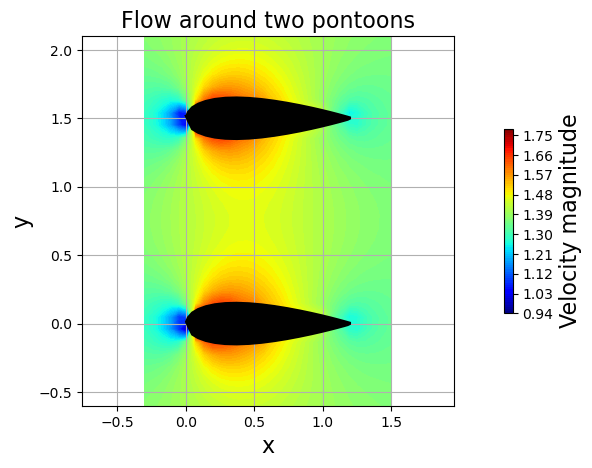

In [3]:
# apply effect of pontoons on river speed (calculate pontoon volume)
mean_pontoon_velocity = main_pontoon_calc(foil_width, turbine_width, pontoon_length,river_vel,plot=True)
river_vel = mean_pontoon_velocity

In [4]:
# calculate the area of the turbine
pontoon_area = calc_naca_area(foil_width)

In [5]:
print('Pontoon area: ', pontoon_area)
print('Mean pontoon velocity: ', mean_pontoon_velocity)

Pontoon area:  0.20533427225358855
Mean pontoon velocity:  1.50699427410696


In [6]:
# how tall do the pontoons need to be to support the turbine?
turbine_mass = 100
pontoon_height = pontoon_height_calc(pontoon_area, turbine_mass)
print('Pontoon height: ', pontoon_height)

Pontoon height:  0.24350538003831051


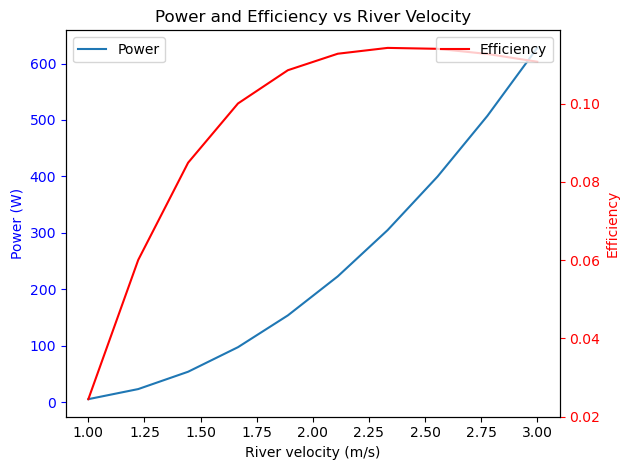

In [7]:
# calculate RPM (using the velocity model for shaft power output)
v = np.linspace(1,3,10)

p_array = power(v, runner_diameter=turbine_diameter, r_drum=r_drum, L=turbine_width/2, RPM=18)

max_power_array = []
# compare to the power of that flow to get the efficiency
blade_area = ((turbine_diameter/2) - r_drum) * turbine_width
for i in range(len(v)):
    p, _,_,_,_ = power_calc(efficiency=1,V=v[i],A=blade_area)
    max_power_array.append(p)

# overall efficiency
eff = p_array/max_power_array
efficiency = max(eff)

# plot power vs velocity and efficiency vs velocity on the same plot
fig, ax1 = plt.subplots()
ax1.plot(v,p_array, label='Power')
ax1.set_xlabel('River velocity (m/s)')
ax1.set_ylabel('Power (W)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_title('Power and Efficiency vs River Velocity')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(v,eff, label='Efficiency', color='r')
ax2.set_ylabel('Efficiency', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()





In [8]:
# with the RPM, power requirements, river velocity, and efficiency estimates for components
# calculate base dimensions for the turbine (width and radius of the turbine) (calculate rough volume of the turbine)

# set RPM to the max power RPM
RPM = 20

# estimate the efficiency of the turbine
generator_eff = 0.9
gearbox_eff = 0.95
drive_efficiency = generator_eff * gearbox_eff
print('Drive efficiency: ', drive_efficiency)

# hydro efficiency is calculated above as 0.12

# power required = 400w
power_required = 300
efficiency = efficiency * drive_efficiency
print('Overall Efficiency: ', efficiency)

# calculate the area required for the turbine
_, _, _, area, _ = power_calc(efficiency=efficiency,V=river_vel,P=power_required)
print('Area required (m^2): ', area)


Drive efficiency:  0.855
Overall Efficiency:  0.09769156448746233
Area required (m^2):  0.8972828838625011


In [9]:
# using the above calculate the required blade thickness (with additional input of material properties)
# define the material properties
sigma_y = 23.5e6
worst_case_vel = 3
sf = 1.5
thickness = minimum_blade_thickness(sigma_y, worst_case_vel*sf, turbine_width/2, r_drum, rho=1000, RPM=RPM,CD = 1.28)
print('Blade thickness (mm): ', thickness)

Blade thickness (mm):  7.992549305933374


In [10]:
# run the debris impact model to determine worst case debris size and impact force
# define the material properties
impact_toughness = 2.6 # J/cm^2
size = debris_calc(impact_toughness, thickness, worst_case_vel)
print('Debris length size (mm): ', size)


Debris length size (mm):  334.43397623314286


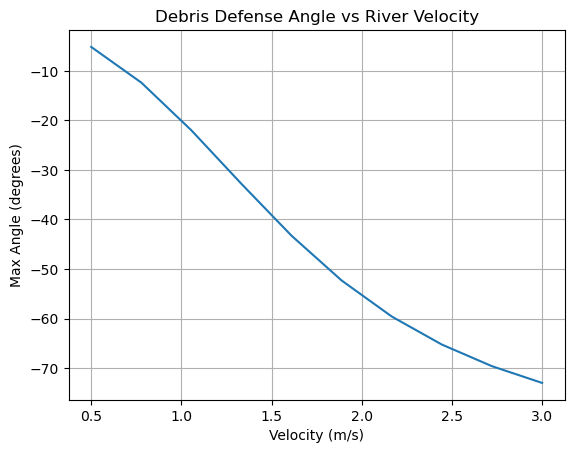

In [11]:
# calculate the angle of the debris defense system to send debris under the turbine
angles = []
velocities = np.linspace(0.5, 3,10 )
for u in velocities:
    angles.append(debris_angle(u, size/1000 ))

# plot the angle vs velocity
plt.plot(velocities, angles)
plt.grid()
plt.xlabel('Velocity (m/s)')
plt.ylabel('Max Angle (degrees)')
plt.title('Debris Defense Angle vs River Velocity')
plt.show()


In [12]:
# using dimensions and inputs calculate the torque on the drive shaft

# calculate the torque on the drive shaft
torque_val = torque(worst_case_vel,turbine_diameter,r_drum, turbine_width/2,RPM)
print('Worst case torque (Nm): ', torque_val)

Worst case torque (Nm):  306.6263731578866
